# Chicago Divvy Bicycle Sharing Data

#### Link Kaggle
https://www.kaggle.com/yingwurenjian/chicago-divvy-bicycle-sharing-data

#### Descrição das features:
<br><b>trip_idID</b> attached to each trip taken
<br><b>year</b>
<br><b>month</b>
<br><b>week</b> week No.
<br><b>day</b> 
<br><b>hour</b> 
<br><b>usertype</b> "Customer" is a rider who purchased a 24-Hour Pass; "Subscriber" is a rider who purchased an Annual Membership
<br><b>gender</b>
<br><b>starttimeday</b> and time trip started, in CST
<br><b>stoptimeday</b> and time trip ended, in CST
<br><b>tripdurationtime</b> of trip in minutes
<br><b>temperature</b>
<br><b>events</b>
<br><b>from_station_idID</b> of station where trip originated
<br><b>from_station_namename</b> of station where trip terminated
<br><b>latitude_startstation</b> latitude
<br><b>longitude_startstation</b> longitude
<br><b>dpcapacity_startnumber</b> of total docks at each station
<br><b>to_station_id</b>
<br><b>to_station_name</b>
<br><b>latitude_end</b>
<br><b>longitude_end</b>
<br><b>dpcapacity_endnumber</b> of total docks at each station

### Bibliotecas

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, BatchNormalization, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks

import warnings

#warnings.filterwarnings('ignore')

### Carregar dataset

In [4]:
#Carregar dataset
path = "data.csv"
df = pd.read_csv(path)

df.shape

(9495235, 23)

### Correções

In [5]:
#Corringindo campo day com 0
df.day =  df.starttime.astype(str).str.slice(8,10).astype(int)

### Novas Features

In [6]:
#Campo data
df['date'] = df.starttime.astype(str).str[:13]  + ':00:00'

#Convertendo para datetime
df.date = pd.to_datetime(df.date)

### Consolidando dados

In [7]:
#Agregação por date
df2 =  df.groupby(['date']).size().reset_index(name='count')

#Date como index
df2.index = df2['date']
del df2['date']

df2.head(5)
df2.tail(5)

,count
date,
2017-12-31 17:00:00,38
2017-12-31 18:00:00,27
2017-12-31 20:00:00,19
2017-12-31 22:00:00,9
2017-12-31 23:00:00,7


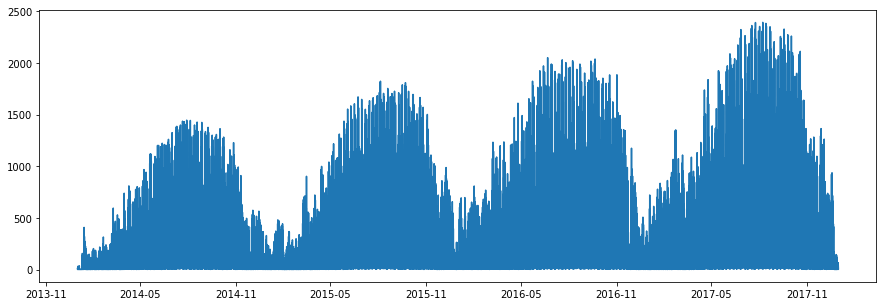

In [8]:
plt.figure(figsize = (15, 5))
plt.plot(df2)
plt.show()

### Normalizando features

In [9]:
values = df2['count'].values.reshape(-1,1)
values = values.astype('float32')
f_norm = MinMaxScaler(feature_range=(0, 1))
v_norm = f_norm.fit_transform(values)

### Particionando Sets

In [11]:
#Definindo o tamanho de cada set
train_size = int(len(v_norm) * 0.8)
test_size  = (5*24)
val_size   = len(v_norm) - train_size - test_size

#Particionando os sets
train = v_norm[0:train_size,:]
val   = v_norm[train_size:(train_size+val_size),:]
test  = v_norm[(train_size+val_size):len(v_norm),:]

#Volume de dados
print('Train:', len(train))
print('Val:  ', len(val))
print('Test: ', len(test))

Train: 27693
Val:   6804
Test:  120


### Definindo Modelo

In [13]:
batch_size=2
time_steps=24

trainGenerator = TimeseriesGenerator(train, train,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
valGenerator = TimeseriesGenerator(val,  val,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)
testGenerator = TimeseriesGenerator(test,  test,
                               length=time_steps, sampling_rate=1,
                               batch_size=batch_size)

#Reshape
#trainX_ = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#valX_   = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

#Dfinindo modelo LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(time_steps, train.shape[1])))

#model.add(Dropout(0.2))
#model.add(Dense(128))
#model.add(BatchNormalization())

model.add(Dense(1))

print(model.summary())

#Compilando Modelo
model.compile(loss='mean_squared_error', optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
None


### Treinando Modelo

In [26]:
epochs = 100
batch_size = 300

#Fit nos dados
history = model.fit_generator(trainGenerator, 
                    steps_per_epoch= 30, 
                    epochs = epochs,
                    validation_data = valGenerator,
                    callbacks=[
                        callbacks.ModelCheckpoint('best.h5', save_best_only=True, save_weights_only=True, verbose=1),
                    ])

model.load_weights('best.h5')

#history = model.fit(trainX_, trainY, epochs=epochs, batch_size=batch_size, validation_data=(valX_, valY))

Epoch 1/100
30/30 [==============================] - 18s 609ms/step - loss: 0.0046 - val_loss: 0.0091

Epoch 00001: val_loss improved from inf to 0.00907, saving model to best.h5
Epoch 2/100
30/30 [==============================] - 18s 611ms/step - loss: 0.0022 - val_loss: 0.0099

Epoch 00002: val_loss did not improve from 0.00907
Epoch 3/100
30/30 [==============================] - 18s 612ms/step - loss: 0.0077 - val_loss: 0.0088

Epoch 00003: val_loss improved from 0.00907 to 0.00882, saving model to best.h5
Epoch 4/100
30/30 [==============================] - 19s 643ms/step - loss: 0.0020 - val_loss: 0.0104

Epoch 00004: val_loss did not improve from 0.00882
Epoch 5/100
30/30 [==============================] - 18s 610ms/step - loss: 0.0079 - val_loss: 0.0084

Epoch 00005: val_loss improved from 0.00882 to 0.00837, saving model to best.h5
Epoch 6/100
30/30 [==============================] - 18s 615ms/step - loss: 0.0030 - val_loss: 0.0085

Epoch 00006: val_loss did not improve from 0


Epoch 00050: val_loss did not improve from 0.00512
Epoch 51/100
30/30 [==============================] - 20s 678ms/step - loss: 0.0031 - val_loss: 0.0049

Epoch 00051: val_loss improved from 0.00512 to 0.00489, saving model to best.h5
Epoch 52/100
30/30 [==============================] - 20s 667ms/step - loss: 0.0021 - val_loss: 0.0057

Epoch 00052: val_loss did not improve from 0.00489
Epoch 53/100
30/30 [==============================] - 19s 631ms/step - loss: 0.0015 - val_loss: 0.0053

Epoch 00053: val_loss did not improve from 0.00489
Epoch 54/100
30/30 [==============================] - 19s 623ms/step - loss: 0.0013 - val_loss: 0.0051

Epoch 00054: val_loss did not improve from 0.00489
Epoch 55/100
30/30 [==============================] - 16s 543ms/step - loss: 0.0023 - val_loss: 0.0055

Epoch 00055: val_loss did not improve from 0.00489
Epoch 56/100
30/30 [==============================] - 17s 576ms/step - loss: 0.0031 - val_loss: 0.0061

Epoch 00056: val_loss did not improve fr

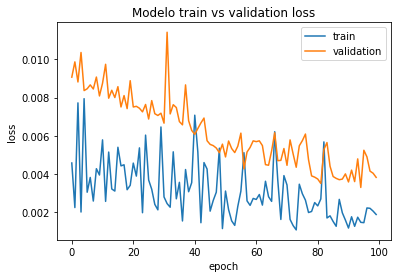

In [27]:
#Plotando
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Predict

ValueError: x and y must have same first dimension, but have shapes (96,) and (120, 1)

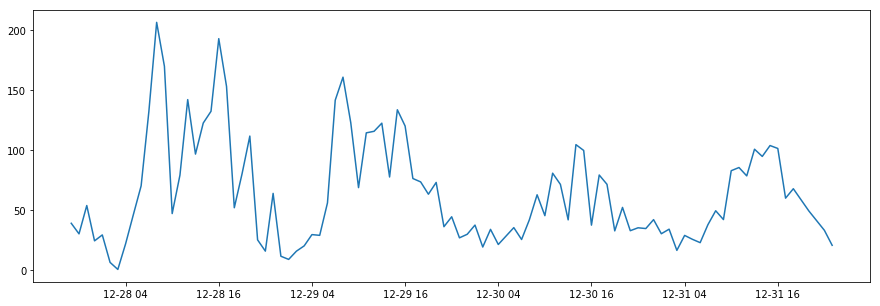

In [29]:
#Reshape test
#testX_ = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Predict
mpred = model.predict_generator(testGenerator)

#Convertendo para valor não normalizado
mpred_inverse = f_norm.inverse_transform(mpred.reshape(-1, 1))
testY_inverse = f_norm.inverse_transform(test.reshape(-1, 1))

#Eixo X do gráfico como data
predictDates = df2.tail(len(mpred_inverse)).index

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predictDates, mpred_inverse, label='Predict')
plt.plot(predictDates, testY_inverse, label='Atual')
plt.legend()
plt.show()

<br>No modelo acima sempre prevemos o número de viagens da próxima hora, porém sempre é passado o valor de viagens da hora atual.
<img src="predict1.png">

<br>A seguir utilizaremos a previsão a longo prazo, utilizando o número inicial de viagens como o da hora atual e os seguintes através da saida do predict.
<img src="predict2.png">

### Predict longo prazo

In [38]:
#Quantidade de itens para o set inicial (número de horas)
n = 48

#Valores iniciais para predição
vetX = []

#N itens do set de test
vetX = testX_[0:n,0,0]
np.array(vetX)

#Faz o predict dos N itens de vetx. Ao final de cada iteração insere o ultimo valor predito
#em vetX para um novo predict.
for i in range(len(testX_)-n+1):
    vetX_ = np.reshape(vetX, (vetX.shape[0], 1, 1))
    mpred_lp = model.predict(vetX_)
    #Insere em vetX o ultimo valor predito de mpredY
    vetX = np.append(vetX, mpred_lp[len(mpred_lp)-1,0])

#Convertendo para valor não normalizado
predY_inverse = f_norm.inverse_transform(mpred_lp.reshape(-1, 1))

#Gráfico
plt.figure(figsize = (15, 5))
plt.plot(predictDates, predY_inverse, label='Predict')
plt.plot(predictDates, testY_inverse, label='Atual')
plt.legend()
plt.show()

ValueError: Error when checking input: expected lstm_4_input to have shape (24, 1) but got array with shape (1, 1)